## Họ và tên: Nguyễn Mạnh Niên
## Mã sinh viên: 20226019541

In [9]:
# Cài đặt các thư viện cần thiết
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Loại bỏ các cảnh báo
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [10]:
# Khai báo các giá trị tham số cố định
PATH_FILE       = '/kaggle/input/data-tx2/data_tx2.csv' # Đường dẫn đến file dữ liệu
RANDOM_STATE    = 42                # Dùng trong chia dữ liệu
TEST_SIZE       = 0.25              # Dùng trong chia dữ liệu
K_FOLD          = 3                 # Dùng trong đánh giá kiểm định chéo
CV              = 5                 # Dùng trong quá trình tìm kiếm tham số tốt nhất
DPI             = 200               # Độ phân giải cho biểu đồ

### a. Đọc dữ liệu từ tệp cho trước và thực hiện phép chuẩn hóa theo phương pháp min-max

In [11]:
# Đọc dữ liệu sử dụng pandas
try:
    # Đọc file CSV
    df = pd.read_csv(PATH_FILE,
                     header = 0, 
                     sep = ',',
                     skipinitialspace = True)
    print('Đọc file thành công!')
    print(df.head(5))   # In ra 5 dòng đầu tiên
except FileNotFoundError:
    print(f"Lỗi: File '{PATH_FILE}' không tồn tại.")
except Exception:
    print(f"Lỗi {Exception}.")

Đọc file thành công!
     A     B    C    D    E     F    G Class
0  9.0  15.0  3.7  2.9  1.2   5.9  4.0     P
1  3.5   4.5  3.1  2.5  2.8  10.0  6.7     N
2  4.1   4.9  2.1  3.7  2.5  10.0  3.3     P
3  4.6   3.5  2.5  2.2  2.7  11.0  7.2     P
4  5.6   1.6  4.1  3.9  4.7   5.6  2.9     N


In [12]:
# Kiểm tra xem dữ liệu có bị thiếu hay không
check_nan = df.isna().any().any()
if check_nan == True:
    print("Dữ liệu bị thiếu!")
else:
    print("Dữ liệu đầy đủ!")

Dữ liệu đầy đủ!


Class
P    8
N    4
Name: count, dtype: int64


<Axes: xlabel='Class', ylabel='count'>

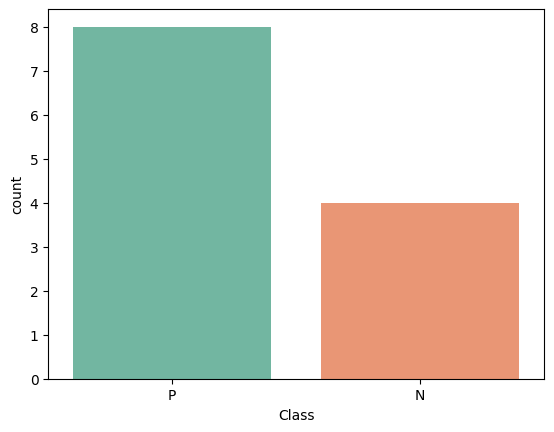

In [13]:
# Kiểm tra tính cân bằng của nhãn
print(df['Class'].value_counts())
sns.countplot(data=df, x = 'Class', palette='Set2')

In [14]:
# Chuyển đổi các thuộc tính dạng ký tự sang số
Le = LabelEncoder()
df['Class'] = Le.fit_transform(df['Class'])

In [15]:
# Chuẩn hóa Min-Max
# Lấy dữ liệu chuẩn hóa từ DataFrame
df_X = df.iloc[:, :-1]
df_y = df.iloc[:, -1]

# Chuẩn hóa dữ liệu
scaler  = MinMaxScaler()
df_X    = scaler.fit_transform(df_X)

### b. Chuẩn bị dữ liệu cho quá trình thực hiện sử dụng phương pháp K-Fold với k = 3